In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import scqubits as qubit
import scqubits.utils.plotting as plot
from scqubits.core.hilbert_space import HilbertSpace, InteractionTerm
from scqubits.core.param_sweep import HilbertSpaceSweep

import numpy as np
import qutip as qt

# Working with composite Hilbert spaces and interfacing with QuTiP

## Example: two Cooper pair boxes coupled to one resonator mode
$\displaystyle H=\sum_{\alpha=1,2}\sum_{j} E_j^{(\alpha)}|\alpha j\rangle\langle \alpha j| + \omega_r a^\dagger a + \sum_{\alpha=1,2}g^{(\alpha)} n_\alpha(a+a^\dagger)$

### Define Hilbert space components, initialize HilbertSpace object

In [2]:
# Set up the components / subspaces of our Hilbert space

CPB1 = qubit.Transmon(
    EJ = 40.0,
    EC = 0.2,
    ng = 0.3,
    ncut = 40,
    truncated_dim = 3     # after diagonalization, we will keep 3 levels
)

CPB2 = qubit.Transmon(
    EJ = 30.0,
    EC = 0.15,
    ng = 0.0,
    ncut = 10,
    truncated_dim = 4
)

resonator = qubit.Oscillator(
    omega = 6.0,
    truncated_dim=4  # up to 3 photons (0,1,2,3)
)


# Form a list of all components making up the Hilbert space.
hilbertspace = HilbertSpace([CPB1, CPB2, resonator])

Obtain the bare Hamiltonian of the non-interacting subsystems:

In [3]:
bare_hamiltonian = hilbertspace.get_bare_hamiltonian()
bare_hamiltonian

Quantum object: dims = [[3, 4, 4], [3, 4, 4]], shape = (48, 48), type = oper, isherm = True
Qobj data =
[[-63.0886372    0.           0.         ...   0.           0.
    0.        ]
 [  0.         -57.0886372    0.         ...   0.           0.
    0.        ]
 [  0.           0.         -51.0886372  ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... -24.66024074   0.
    0.        ]
 [  0.           0.           0.         ...   0.         -18.66024074
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  -12.66024074]]

### Set up interaction terms between individual subsystems

In [4]:
g1 = 0.1  # coupling resonator-CPB1 (without charge matrix elements)
g2 = 0.2  # coupling resonator-CPB2 (without charge matrix elements)

interaction1 = InteractionTerm(
    g_strength = g1,
    hilbertspace = hilbertspace,
    op1 = CPB1.n_operator(),
    subsys1 = CPB1,
    op2 = resonator.creation_operator() + resonator.annihilation_operator(),
    subsys2 =resonator
)

interaction2 = InteractionTerm(
    g_strength = g2,
    hilbertspace = hilbertspace,
    op1 = CPB2.n_operator(),
    subsys1 = CPB2,
    op2 = resonator.creation_operator() + resonator.annihilation_operator(),
    subsys2 =resonator
)

Now insert the interaction terms into the HilbertSpace object.
(Alternatively, directly initialize with an interaction term list.)

In [5]:
interaction_list = [interaction1, interaction2]

hilbertspace.interaction_list = interaction_list

Now that the interactions are specified, the full Hamiltonian of the coupled system can be obtained via:

In [6]:
dressed_hamiltonian = hilbertspace.get_hamiltonian()
dressed_hamiltonian

Quantum object: dims = [[3, 4, 4], [3, 4, 4]], shape = (48, 48), type = oper, isherm = True
Qobj data =
[[-6.30886372e+01  3.00000000e-02  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.00000000e-02 -5.70886372e+01  4.24264069e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.24264069e-02 -5.10886372e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.46602407e+01
   4.24264069e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.24264069e-02
  -1.86602407e+01  5.19615242e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   5.19615242e-02 -1.26602407e+01]]

Since the composite Hamiltonian is a `qubit.Qobj`, The eigenvalues and eigenvectors can be now be obtained via the usual QuTiP routine:

In [27]:
evals, evecs = dressed_hamiltonian.eigenstates()
print(evals)

[-36.99001175 -32.24866076 -31.31265573 -31.00050268 -29.18360821
 -26.2667945  -25.3298991  -25.01101597 -24.44227302 -23.50626874
 -23.19664463 -21.58212262 -20.28463236 -19.97924801 -19.34700695
 -19.01177557 -18.46294027 -17.52604685 -17.20857162 -16.84063003
 -15.90476673 -15.54545207 -14.25468928 -13.99430821 -13.32972383
 -12.48221619 -12.1728526  -11.54431976 -11.25614429 -10.81137004
  -9.87473197  -9.51023081  -8.00940102  -6.49980972  -6.1904587
  -5.57477478  -4.78367131  -4.57138146  -3.84559808  -3.58345112
  -2.01743549  -0.20699916   1.17347773   1.4608357    2.09826709
   5.73790476   7.49150961  13.41012328]


# Sweeping over an external parameter

scqubits provides the class `HilbertSpaceSweep` to facilitate computation of spectra as function of an external parameter. For efficient usage in the `Explorer` class, computed bare and dressed spectral data are stored internally. A sweep object is initialized as follows.

Consider the case where both `CPB1` and `CPB2` subsystems are flux-tunable split-junction transmons with different loop areas. 

In [35]:
param_name = 'flux'                          # name of varying external parameter
param_vals = np.linspace(-0.5, 0.5, 100)     # parameter values

subsys_update_list = [CPB1, CPB2]                  # list of HilbertSpace subsystems which are affected by parameter changes         

def update_hilbertspace(param_val, hilbertspace):     # function that shows how Hilbert space components are updated
    hilbertspace[0].EJ = 20*np.abs(np.cos(np.pi * param_val))
    hilbertspace[1].EJ = 15*np.abs(np.cos(np.pi * param_val * 0.8))
    
    
sweep = HilbertSpaceSweep(
    param_name=param_name,
    param_vals=param_vals,
    evals_count=10,
    hilbertspace=hilbertspace,
    subsys_update_list=subsys_update_list,
    update_hilbertspace=update_hilbertspace,
    interaction_list=interaction_list
)


Once the data has been generated, the spectrum can be plotted as a function of the parameter value:

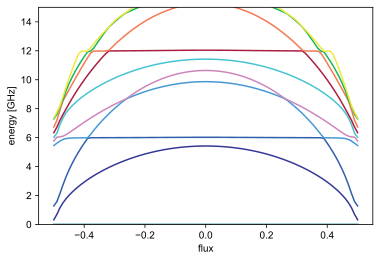

In [38]:
sweep.plot_dressed_spectrum();